## Evaluating New Object ID Methods

1. Raise the minimum threshold for object ID (2/18) 
2. Raise the minimum threhsold for ensemble storm track QC

In [1]:
import xarray as xr 
from glob import glob
import sys
sys.path.insert(0, '/home/monte.flora/python_packages/MontePython')
import monte_python
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import numpy as np
from WoF_post.wofs.plotting.wofs_colors import WoFSColors
from scipy.ndimage import maximum_filter, gaussian_filter, minimum_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams["animation.html"] = "jshtml"

%matplotlib inline

In [2]:
# User-defined parameters
date = '20210504'
init_time = '2000'
ENSEMBLE_SIZE=18

In [3]:
def plot_probs(x,y,z, ax, fig, probs=True):
    if probs:
        levels = np.arange(0, 1.1, 0.1)
    else:
        levels = np.arange(0, 101, 1)
        
    z = np.ma.masked_where(z==0, z)
    cf = ax.contourf(x,y,z, levels=levels, cmap=WoFSColors.wz_cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    fig.colorbar(cf, cax=cax)
    
    ax.grid(alpha=0.8, ls='dashed')
    
    return ax

In [4]:
def id(input_data):

    param_set = [ {'min_thresh': 0,
                   'max_thresh': 100,
                   'data_increment': 10,
                   'delta': 0,
                   'area_threshold': 1000,
                   'dist_btw_objects': 125 },
             
             {'min_thresh': 20,
                   'max_thresh': 100,
                   'data_increment': 5,
                   'delta': 0,
                   'area_threshold': 500,
                   'dist_btw_objects': 15 },

            ]

    params = {'params': param_set }

    # Less than 2/18 = 0.11
    new_input_data = np.copy(input_data)
    new_input_data[input_data<=0.12] = 0

    new_input_data = maximum_filter(new_input_data, size=2)
    new_input_data = gaussian_filter(new_input_data, 1)*100

    storm_labels, new_object_props = monte_python.label(  input_data = new_input_data, 
                       method ='iterative_watershed', 
                       return_object_properties=True, 
                       params = params,  
                       )
    
    storm_labels = minimum_filter(storm_labels, size=2)
    new_object_props = regionprops(storm_labels, storm_labels)
    
    return storm_labels, new_input_data, new_object_props
    
    
# Quality Control
#qcer = monte_python.QualityControler()
#qc_params = [('min_area', 35)]
#new_labels, new_props = qcer.quality_control(storms, storm_labels, object_props, qc_params)

In [5]:
current_labels = []
current_props = [] 
current_data = []

new_labels = [] 
new_props = []
new_data = []

time_rng = range(6, 24+1)

for t in time_rng:
    track_file = glob(f'/work/mflora/SummaryFiles/{date}/{init_time}/wofs_ENSEMBLETRACKS_{t:02d}*')[0]
    ds = xr.load_dataset(track_file)
    current_objs = ds['w_up__ensemble_tracks'].values
    input_data = ds['w_up__ensemble_probabilities'].values
    object_props = regionprops(current_objs, input_data)
    
    current_labels.append(current_objs)
    current_props.append(object_props)
    current_data.append(input_data)
    
    storm_labels, new_input_data, new_object_props = id(input_data)
    new_labels.append(storm_labels)
    new_props.append(new_object_props)
    new_data.append(new_input_data)

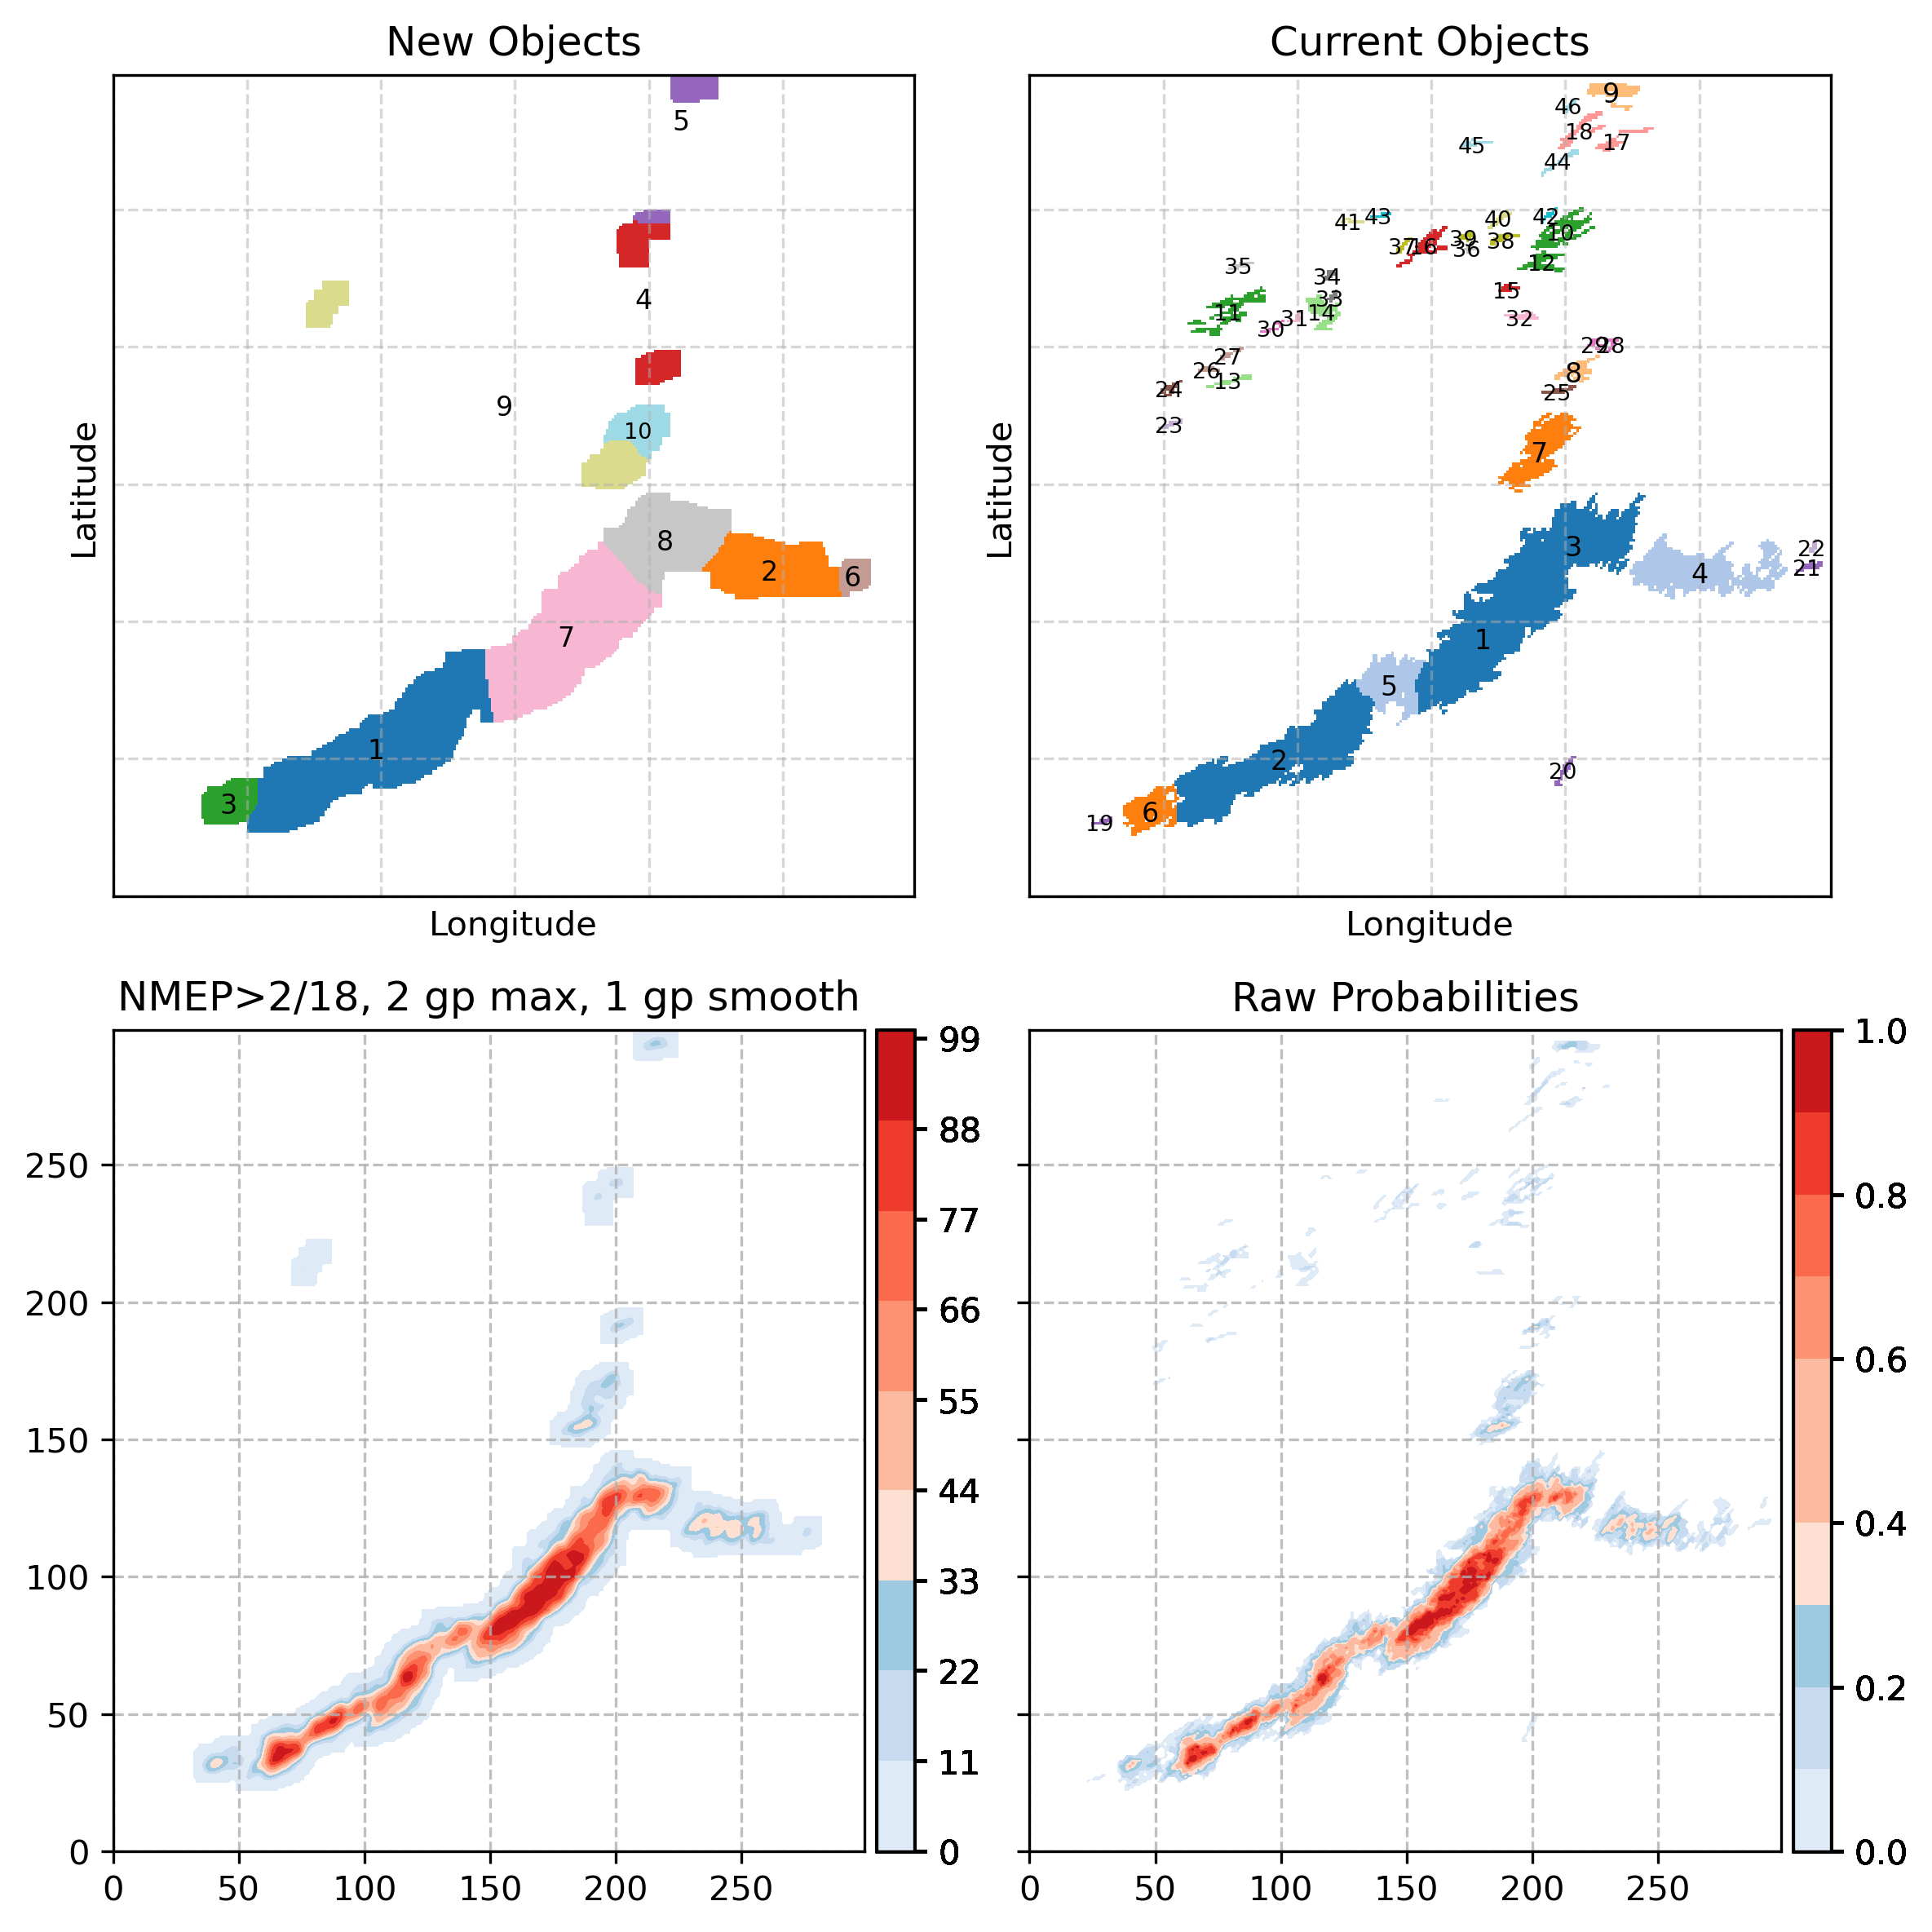

In [8]:
fig, axes = plt.subplots(dpi=300, ncols=2, nrows=2, figsize=(8,8), sharey=True)

x, y = np.meshgrid(np.arange(len(input_data)), np.arange(len(input_data)))

plot_probs(x, y, new_data[0], ax=axes[1,0], fig=fig, probs=False)
plot_probs(x, y, current_data[0], ax=axes[1,1], fig=fig, probs=True)

axes[1,0].set_title('NMEP>2/18, 2 gp max, 1 gp smooth')
axes[1,1].set_title('Raw Probabilities')

monte_python.plot_storm_labels(x, y, new_labels[0], new_props[0], ax=axes[0,0])
axes[0,0].set_title('New Objects')
axes[0,1].set_title('Current Objects')
monte_python.plot_storm_labels(x, y, current_labels[0], current_props[0], ax=axes[0,1]) 


def animate(i):
    for ax in axes.flat:
        ax.clear()
    
    plot_probs(x, y, new_data[i], ax=axes[1,0], fig=fig, probs=False)
    plot_probs(x, y, current_data[i], ax=axes[1,1], fig=fig, probs=True)
    
    axes[1,0].set_title('NMEP>2/18, 2 gp max, 1 gp smooth')
    axes[1,1].set_title('Raw Probabilities')
    monte_python.plot_storm_labels(x, y, new_labels[i], new_props[i], ax=axes[0,0])
    axes[0,0].set_title('New Objects')
    axes[0,1].set_title('Current Objects')
    monte_python.plot_storm_labels(x, y, current_labels[i], current_props[i], ax=axes[0,1]) 


# call the animator. blit=True means only re-draw the parts that have changed.
plt.tight_layout()
anim = FuncAnimation(fig, animate, frames=len(time_rng), interval=40, repeat=True, blit=False)
HTML(anim.to_jshtml())
anim.save(f'tune_object_{date}.gif', writer='pillow', fps=30)